# Analisa Data Marketing Funnel Olist (E-Commerce Brazil)

_______

This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

A seller join Olist through a marketing and sales funnel that was made public at this dataset. Description of steps:

1. Sign-up at a landing page.
2. Get contacted by a Sales development Representative (SDR), confirm some information and schedule a consultancy.
3. Consultancy is made by a Sales Representative (SR). The SR may close the deal (lead sing up) or lose the deal (led leaves without sign in)
4. Lead becomes a seller and starts building his catalog on Olist.
5. His products are published on marketplaces and ready to sell!

Data : https://www.kaggle.com/olistbr/marketing-funnel-olist

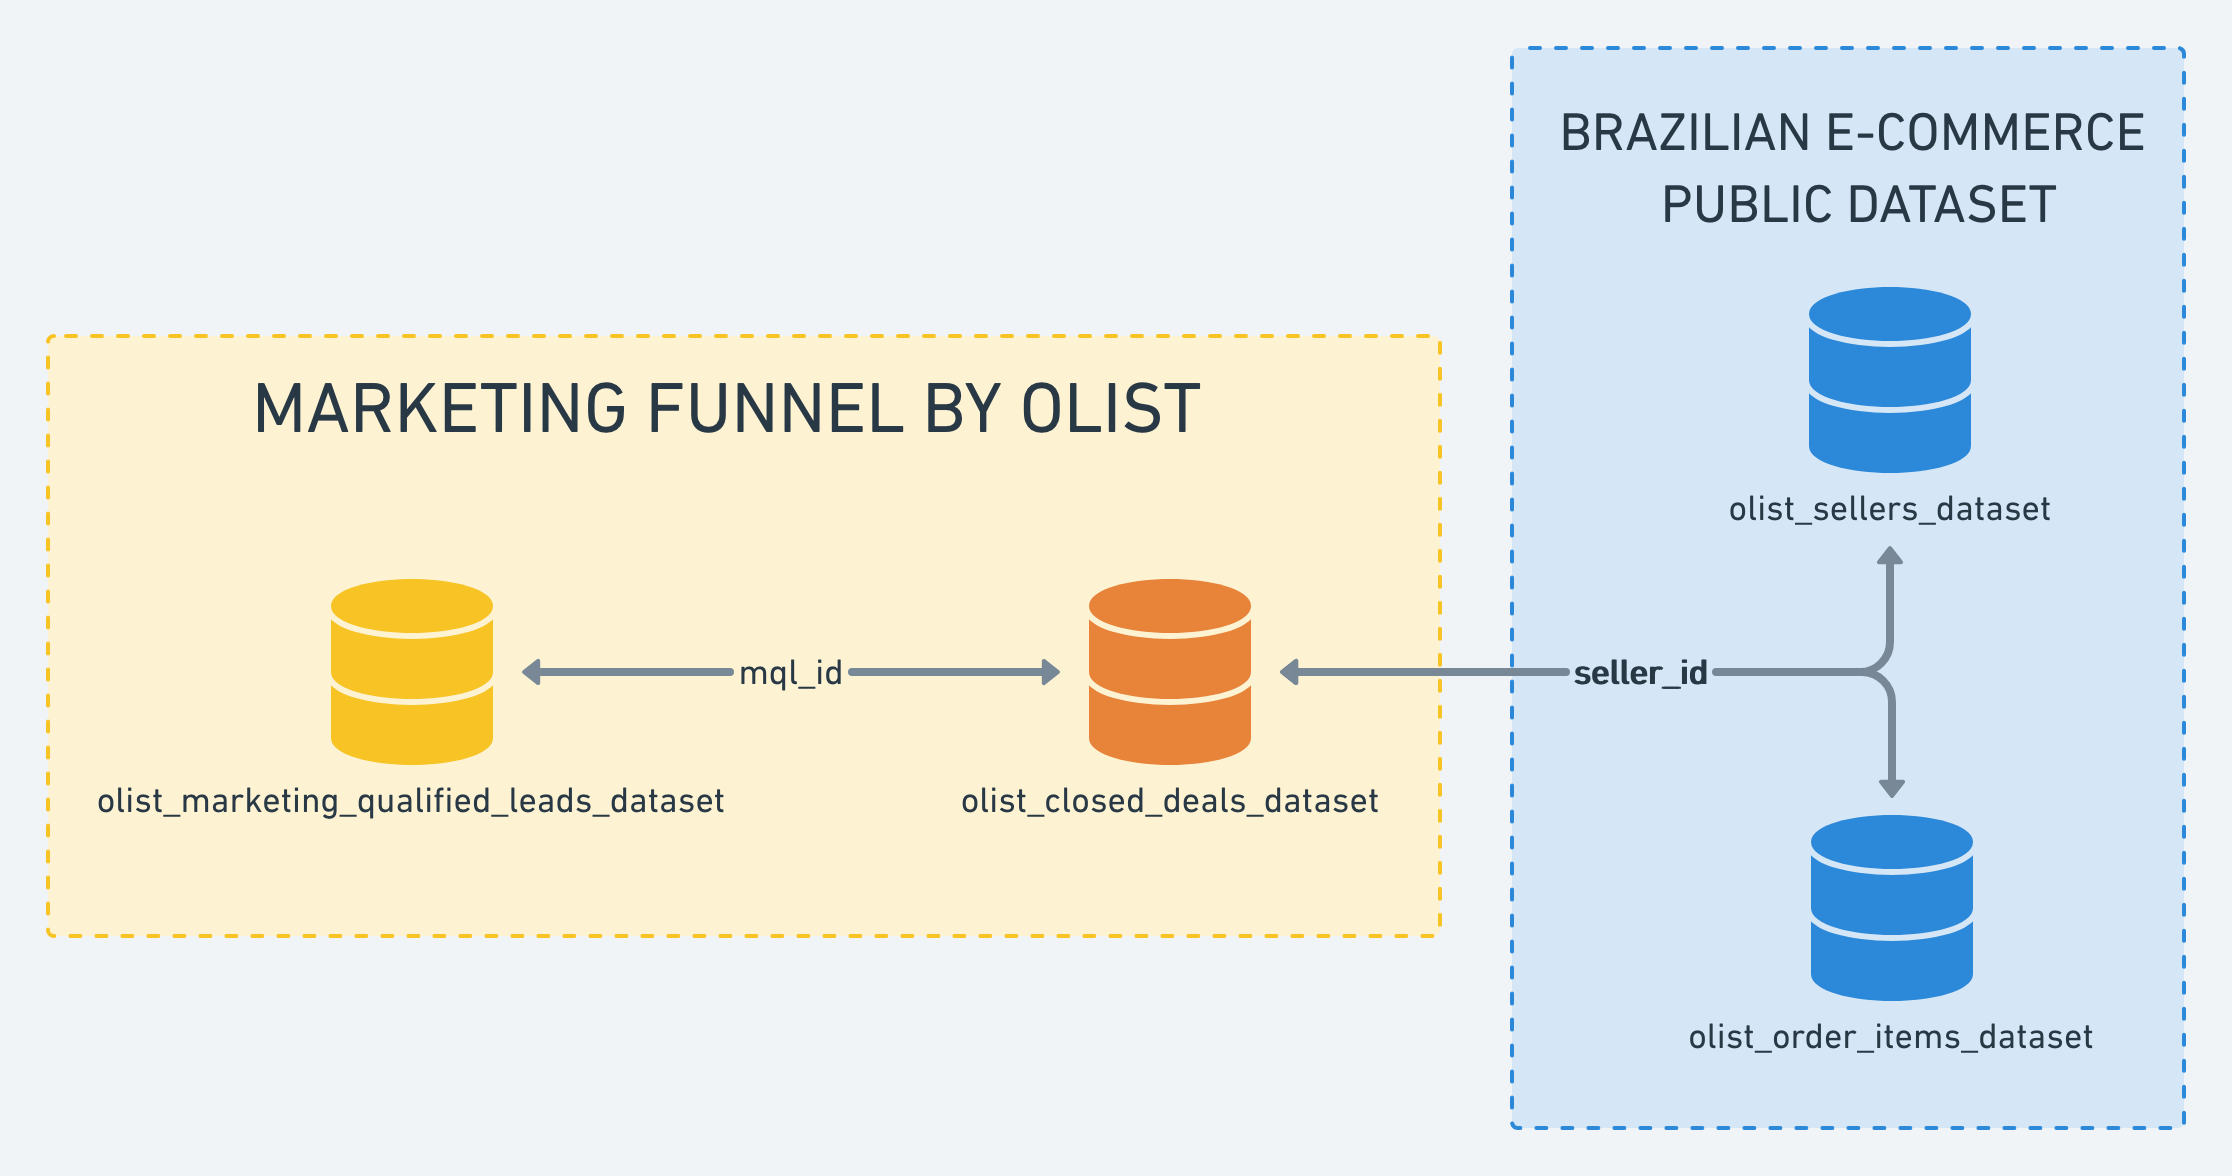

In [1]:
#import necessary library

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid', {'grid.linestyle': '--'})

In [2]:
#Merge datasets based on the data scheme

# closed deal data set
cd = pd.read_csv("olist_closed_deals_dataset.csv")

# leads deal data set (marketing quaified dataset)
mql = pd.read_csv("olist_marketing_qualified_leads_dataset.csv")

# marketing funnel dataset (NaNs are leads that did not close a deal)
mf = mql.merge(cd, on='mql_id', how='left')

# Sellers dataset
sellers = pd.read_csv("olist_sellers_dataset.csv")

# marketing funnel merged with sellers (this way you get seller location) - we're using this datasets
mf_sellers = mf.merge(sellers, on='seller_id', how='left')

# order items dataset
items = pd.read_csv('olist_order_items_dataset.csv')

# Main Datasets

In [3]:
# marketing funnel merged with items (this way you get products sold by sellers)
mf_items = mf.merge(items, on='seller_id', how='left')

-------------------

# Objectives

1. Marketing performence: how effective the marketing?
2. conversion performence: how much the clients become a seller
3. Client Characteristics: what client that they have, what is the characteristics and how much they worth in the future

-----------------------------

# 1. Marketing performence

A. most effective marketing source

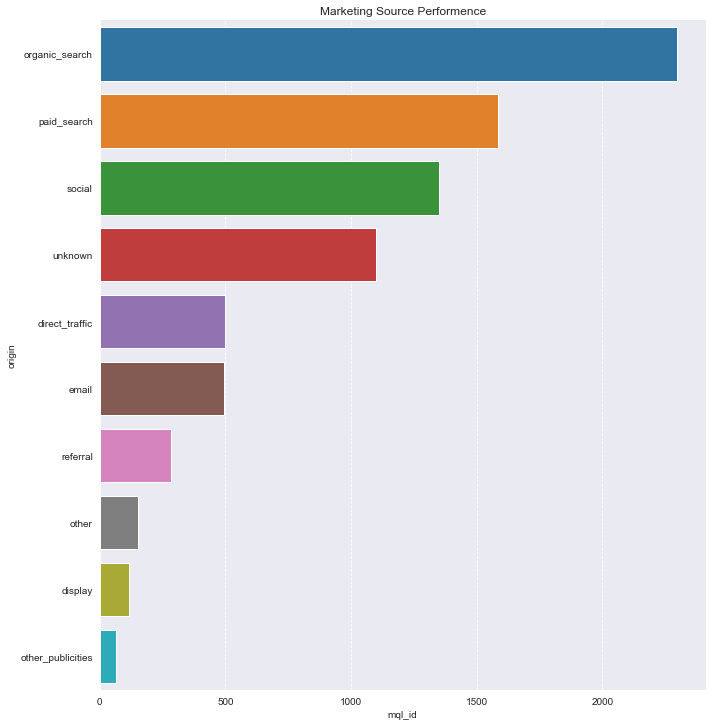

In [4]:
#most effective marketing source

mql_byOrigin = mql.groupby(["origin"]).mql_id.count().sort_values(ascending=False).reset_index()

sns.catplot(x="mql_id", y= "origin", kind="bar",
            height=10, aspect=1, data=mql_byOrigin).set(title='Marketing Source Performence')

B. most effective marketing source by time

Text(0.5, 1, 'Marketing Source by time')

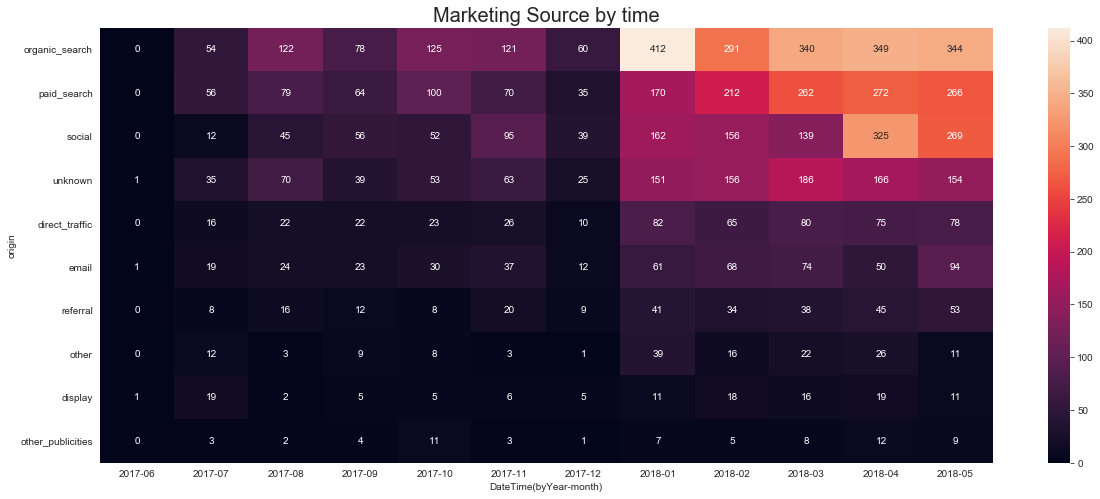

In [7]:
#most effective marketing source by time

mql_pivot = mql.pivot_table(index='origin', columns='DateTime(byYear-month)', values='mql_id',
                aggfunc='count', fill_value = 0)


# new_index for pivot
new_index = mql_byOrigin.set_index('origin').index
mql_pivot_new = mql_pivot.reindex(new_index)

#visual
plt.figure(figsize=(20,8))
sns.heatmap(mql_pivot_new, annot=True, fmt='g')

plt.title('Marketing Source by time', fontsize=20)

C. log in time series

Text(0.5, 1.0, 'MQL Log in (2017-2018)')

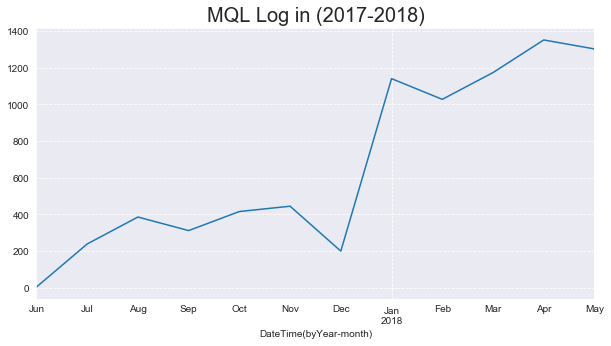

In [6]:
#mql time series

mql_bytime = mql.groupby(["first_contact_date"]).agg("count").reset_index()
mql_bytime['first_contact_date'] = pd.to_datetime(mql_bytime['first_contact_date'])
mql['first_contact_date'] = pd.to_datetime(mql['first_contact_date'])
mql['DateTime(byYear-month)'] = mql['first_contact_date'].dt.to_period('M')
mql_byMonth = mql.groupby('DateTime(byYear-month)').mql_id.count() # groupby with counting the mql_id without multiindex

mql_byMonth.plot.line(figsize=(10, 5)) # using .plot bcs datetime func

plt.title('MQL Log in (2017-2018)', fontsize=20)

- A. bila hanya melihat data saja tanpa mengetahui latar belakangnya, organic search justru sumber marketing paling efektif, sedangkan marketing dengan jasa berbayar justru tidak lebih efektif. artinya keyword Olist sudah mampu ditemukan orang-orang pada umumnya.

- B. Organic search puncaknya di januari dan menjadi yang paling besar (hampir 2x lipatnya) diantara bulan-bulan setelahnya, kemudian organic search cendrung stabil di angka 200an. paid search cukup menunjukan performa yang baik dengan kecendrungan setabil dari awal tahun. sumber marketing yang efekti berada di kotak paling atas dengan sejumlah diatas 100. maka bisa fokus mengembangkan 3 sumber marketing

- C. secara umum, MQL log in melakukan peningkatan baru di tahun 2018

# 2. Conversion Performence

A. Closed Deal Means Interval

In [4]:
# mf data Cleansing

mf = mf.replace({'sdr_id': {np.nan: "not closed"},
           'sr_id': {np.nan: "not closed"},
           'won_date': {np.nan: "not closed"}
           })

mf = mf.replace(np.nan, '-', regex=True)


Text(0.5, 1.0, 'Closed Deal Means Interval')

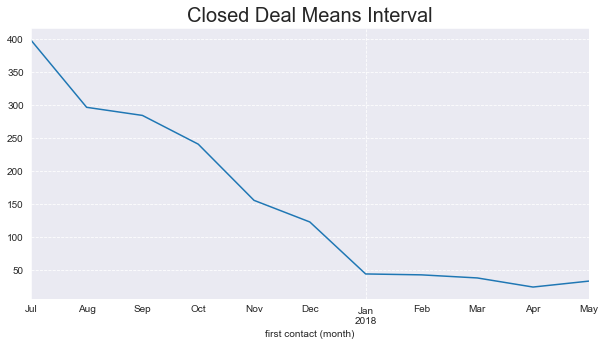

In [5]:
data = {'first contact' : mf["first_contact_date"], 'won' : mf["won_date"]}
mf_conversion = pd.DataFrame(data, columns = ['first contact', 'won'])
mf_conversion = mf_conversion[mf_conversion['won'] != 'not closed' ].reset_index().drop(columns = 'index')
mf_conversion["won"] = mf_conversion["won"].str[0:10]
mf_conversion["first contact"] = pd.to_datetime(mf_conversion["first contact"])
mf_conversion["won"] = pd.to_datetime(mf_conversion["won"])
mf_conversion['Days'] = (mf_conversion['won'] - mf_conversion['first contact']).dt.days
mf_conversion['first contact (month)'] = mf_conversion['first contact'].dt.to_period('M')
mf_conversion['won (month)'] = mf_conversion['won'].dt.to_period('M')

conversion_byMonth = mf_conversion.groupby('first contact (month)').Days.mean()

conversion_byMonth.plot(figsize=(10, 5))

plt.title('Closed Deal Means Interval', fontsize=20)

Text(0.5, 1.0, 'Rata-rata lamanya hingga closing (with std)')

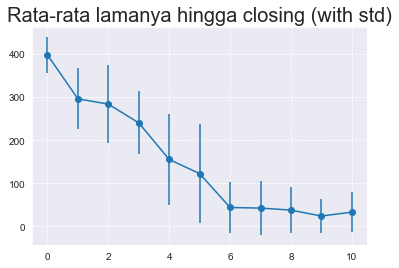

In [6]:
mf_conversion_std_mean = mf_conversion.groupby("first contact (month)").agg([np.mean, np.std]).reset_index().reset_index()

#with STD

import matplotlib.pyplot as plt
x = mf_conversion_std_mean['index']
y = mf_conversion_std_mean['Days']['mean']
yerr = mf_conversion_std_mean['Days']['std']

plt.errorbar(x, y, yerr=yerr, fmt='-o')
plt.title('Rata-rata lamanya hingga closing (with std)', fontsize=20)

B. Conversion Rate

Text(0.5, 1.0, 'Conversion (%)')

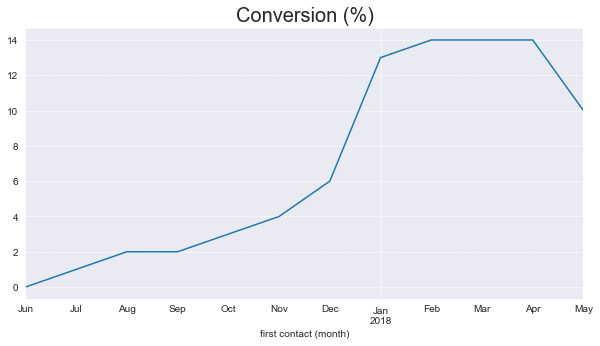

In [7]:
mf["closed"] = mf['seller_id'] != "-"
mf['first_contact_date'] = pd.to_datetime(mf['first_contact_date'])
mf['first contact (month)'] = mf['first_contact_date'].dt.to_period('M')
mf_closed = mf.groupby('first contact (month)')['closed'].agg(['count', 'sum'])
mf_closed['%'] = ((mf_closed['sum'] / mf_closed['count']) * 100).round(0)
mf_closed['%'].plot(figsize=(10, 5))

plt.title('Conversion (%)', fontsize=20)

sebelum 2018, jarak dihubungi hingga closing bisa lebih dari setahun baru mengkonfirmasi. melihat kurva sebelumnya, marketing juga baru marak setelah tahun 2018. jadi masuk akal bila setelah tahun 2018 konfirmasinya rata-rata 1 bulan. kemudian dengan melihat conversion rate, selama 4 bulan di awal tahun, orang yang berubah dari MQL menjadi seller sebesar 13%-14% dan kemudian kembali turun dibulan berikutnya

----------------------

# 3. Client Characteristics

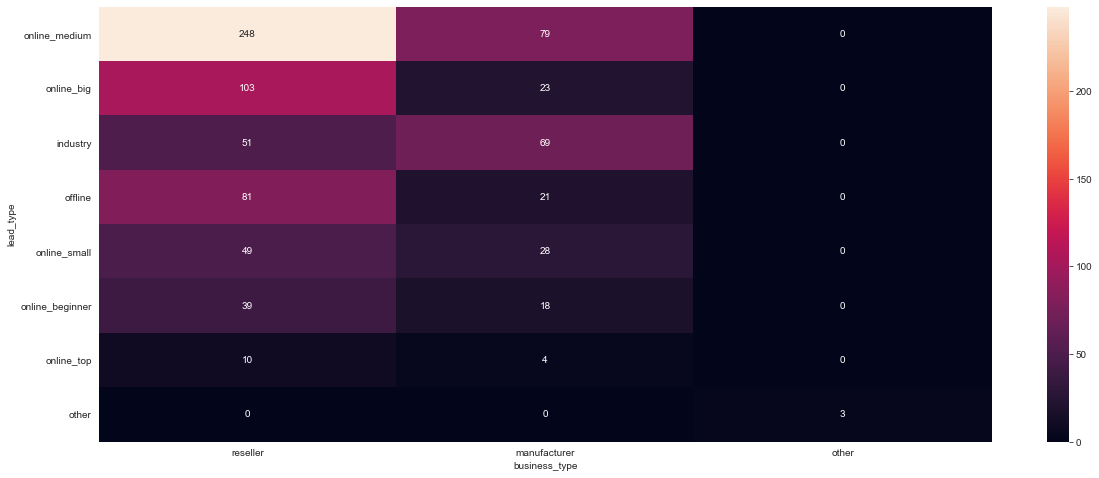

In [8]:
mf_lead_business_pivot = mf.pivot_table(index='lead_type', columns='business_type', values='mql_id',aggfunc='count', fill_value = 0)
mf_lead_business_pivot = mf_lead_business_pivot.drop('-').drop(mf_lead_business_pivot.columns[0], axis=1)

#new index
mf_lead_type = mf.groupby('lead_type').mql_id.count().sort_values(ascending=False).reset_index().drop(0)
new_index_lead_business = mf_lead_type.set_index('lead_type').index
mf_lead_business_pivot = mf_lead_business_pivot.reindex(new_index_lead_business)

#new column
mf_byBusiness = mf.groupby('business_type').mql_id.count().sort_values(ascending=False).reset_index().drop(0)
new_col_lead_business = mf_byBusiness.set_index('business_type').index
mf_lead_business_pivot_new = mf_lead_business_pivot.reindex(columns=new_col_lead_business)

plt.figure(figsize=(20,8))
sns.heatmap(mf_lead_business_pivot_new, annot=True, fmt='g')

In [55]:
seg_pivot = mf_items.pivot_table(index='business_segment', columns='business_type', values='price',aggfunc='sum', fill_value = 0).drop(columns = "other")

#new index
seg_pivot_index = mf_items.groupby('business_segment').price.sum().sort_values(ascending=False).index
seg_pivot_new = seg_pivot.reindex(seg_pivot_index)

seg_pivot_new2 = seg_pivot_new.reindex(columns=["reseller", "manufacturer"])
seg_pivot_new2

business_type,reseller,manufacturer
business_segment,,
watches,117278.87,0.00
health_beauty,82073.39,8762.43
household_utilities,38167.93,13400.83
audio_video_electronics,39393.74,10871.60
small_appliances,46774.97,0.00
home_decor,32559.35,11542.87
pet,37874.50,2624.33
construction_tools_house_garden,29886.52,4652.22
car_accessories,23110.18,7064.80


Olis harus lebih mengoptimalkan client-client di beberapa bidang, khususnya: Reseller industri Jam (watches) dan bisnis Online medium. pendapatan total industri jam besar, namun dia sama sekali tidak ada manufaktur.